# Exploratory Data Analysis: Defensemen Position

Recall that our **y**-values are the proportion of the salary cap that a general manager is willing to spend on a player in a given year. To estimate how much this value is, given a players performance metrics, we need to dive into the data and figure out what metrics have a strong relationship with our **y**'s.

Based on my knowledge of hockey, I suspect that the features will differ for the different positions that exist in hockey: Center, Forward, Defence, and Goalie. Here I will explore the data with respect to the defensemen position.

In [11]:
import pandas as pd
import dataprep as dp
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot

In [12]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

data.shape

(12953, 230)

Now we need to select only those players that play Defense.

In [13]:
# Get all the unique values in the 'Position' col
data['POSITION'].unique()

array(['r', 'd', 'l', 'c, l', 'c', 'l, r', 'c, r', 'd, l'], dtype=object)

It appears that some players in our dataset play both defensemen and left wing (forward). That is unusual and rather unique, so we should take a look at how many players there are and if we should consider them for training or not.

In [14]:
# Select all rows were the 'Position' is 'c' or 'c,l' or 'c,r'
toCheck = data[data['POSITION'].isin(['d, l'])]
toCheck.shape

(1, 230)

Given that there's only a single player, I think it's fine either way if we leave them in or discard them from our data. Let's just leave them in for simplicity.

In [5]:
defensemen = data[data['POSITION'].isin(['d, l', 'd'])]
defensemen.shape

(4553, 230)

Now there's going to be some strange numbers in our data if we include players who have only played a few games, and happened to perform quite well during them. So, let's choose a value of 41 GP which represents about 1/2 of the season. This way we can get rid of players who have only really had a small taste of the NHL in a given season.

In [6]:
defensemen_41GP = defensemen[defensemen['GP'] >= 41]
defensemen_41GP.shape

(2871, 230)

We have reduced our records significantly, but we still have 2871 to work with, which seems like a healthy amount.

In [7]:
# plot(defensemen_41GP)

## Correlation Analysis

To start our EDA, I want to perform a correlation analysis and zoom in on any features that are highly correlated with our **y** values.

/var/folders/jd/f_rvzywd5j7g5f9ckcp7wsxr0000gp/T/ipykernel_71387/1769875106.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = defensemen_41GP.corr()


<Axes: >

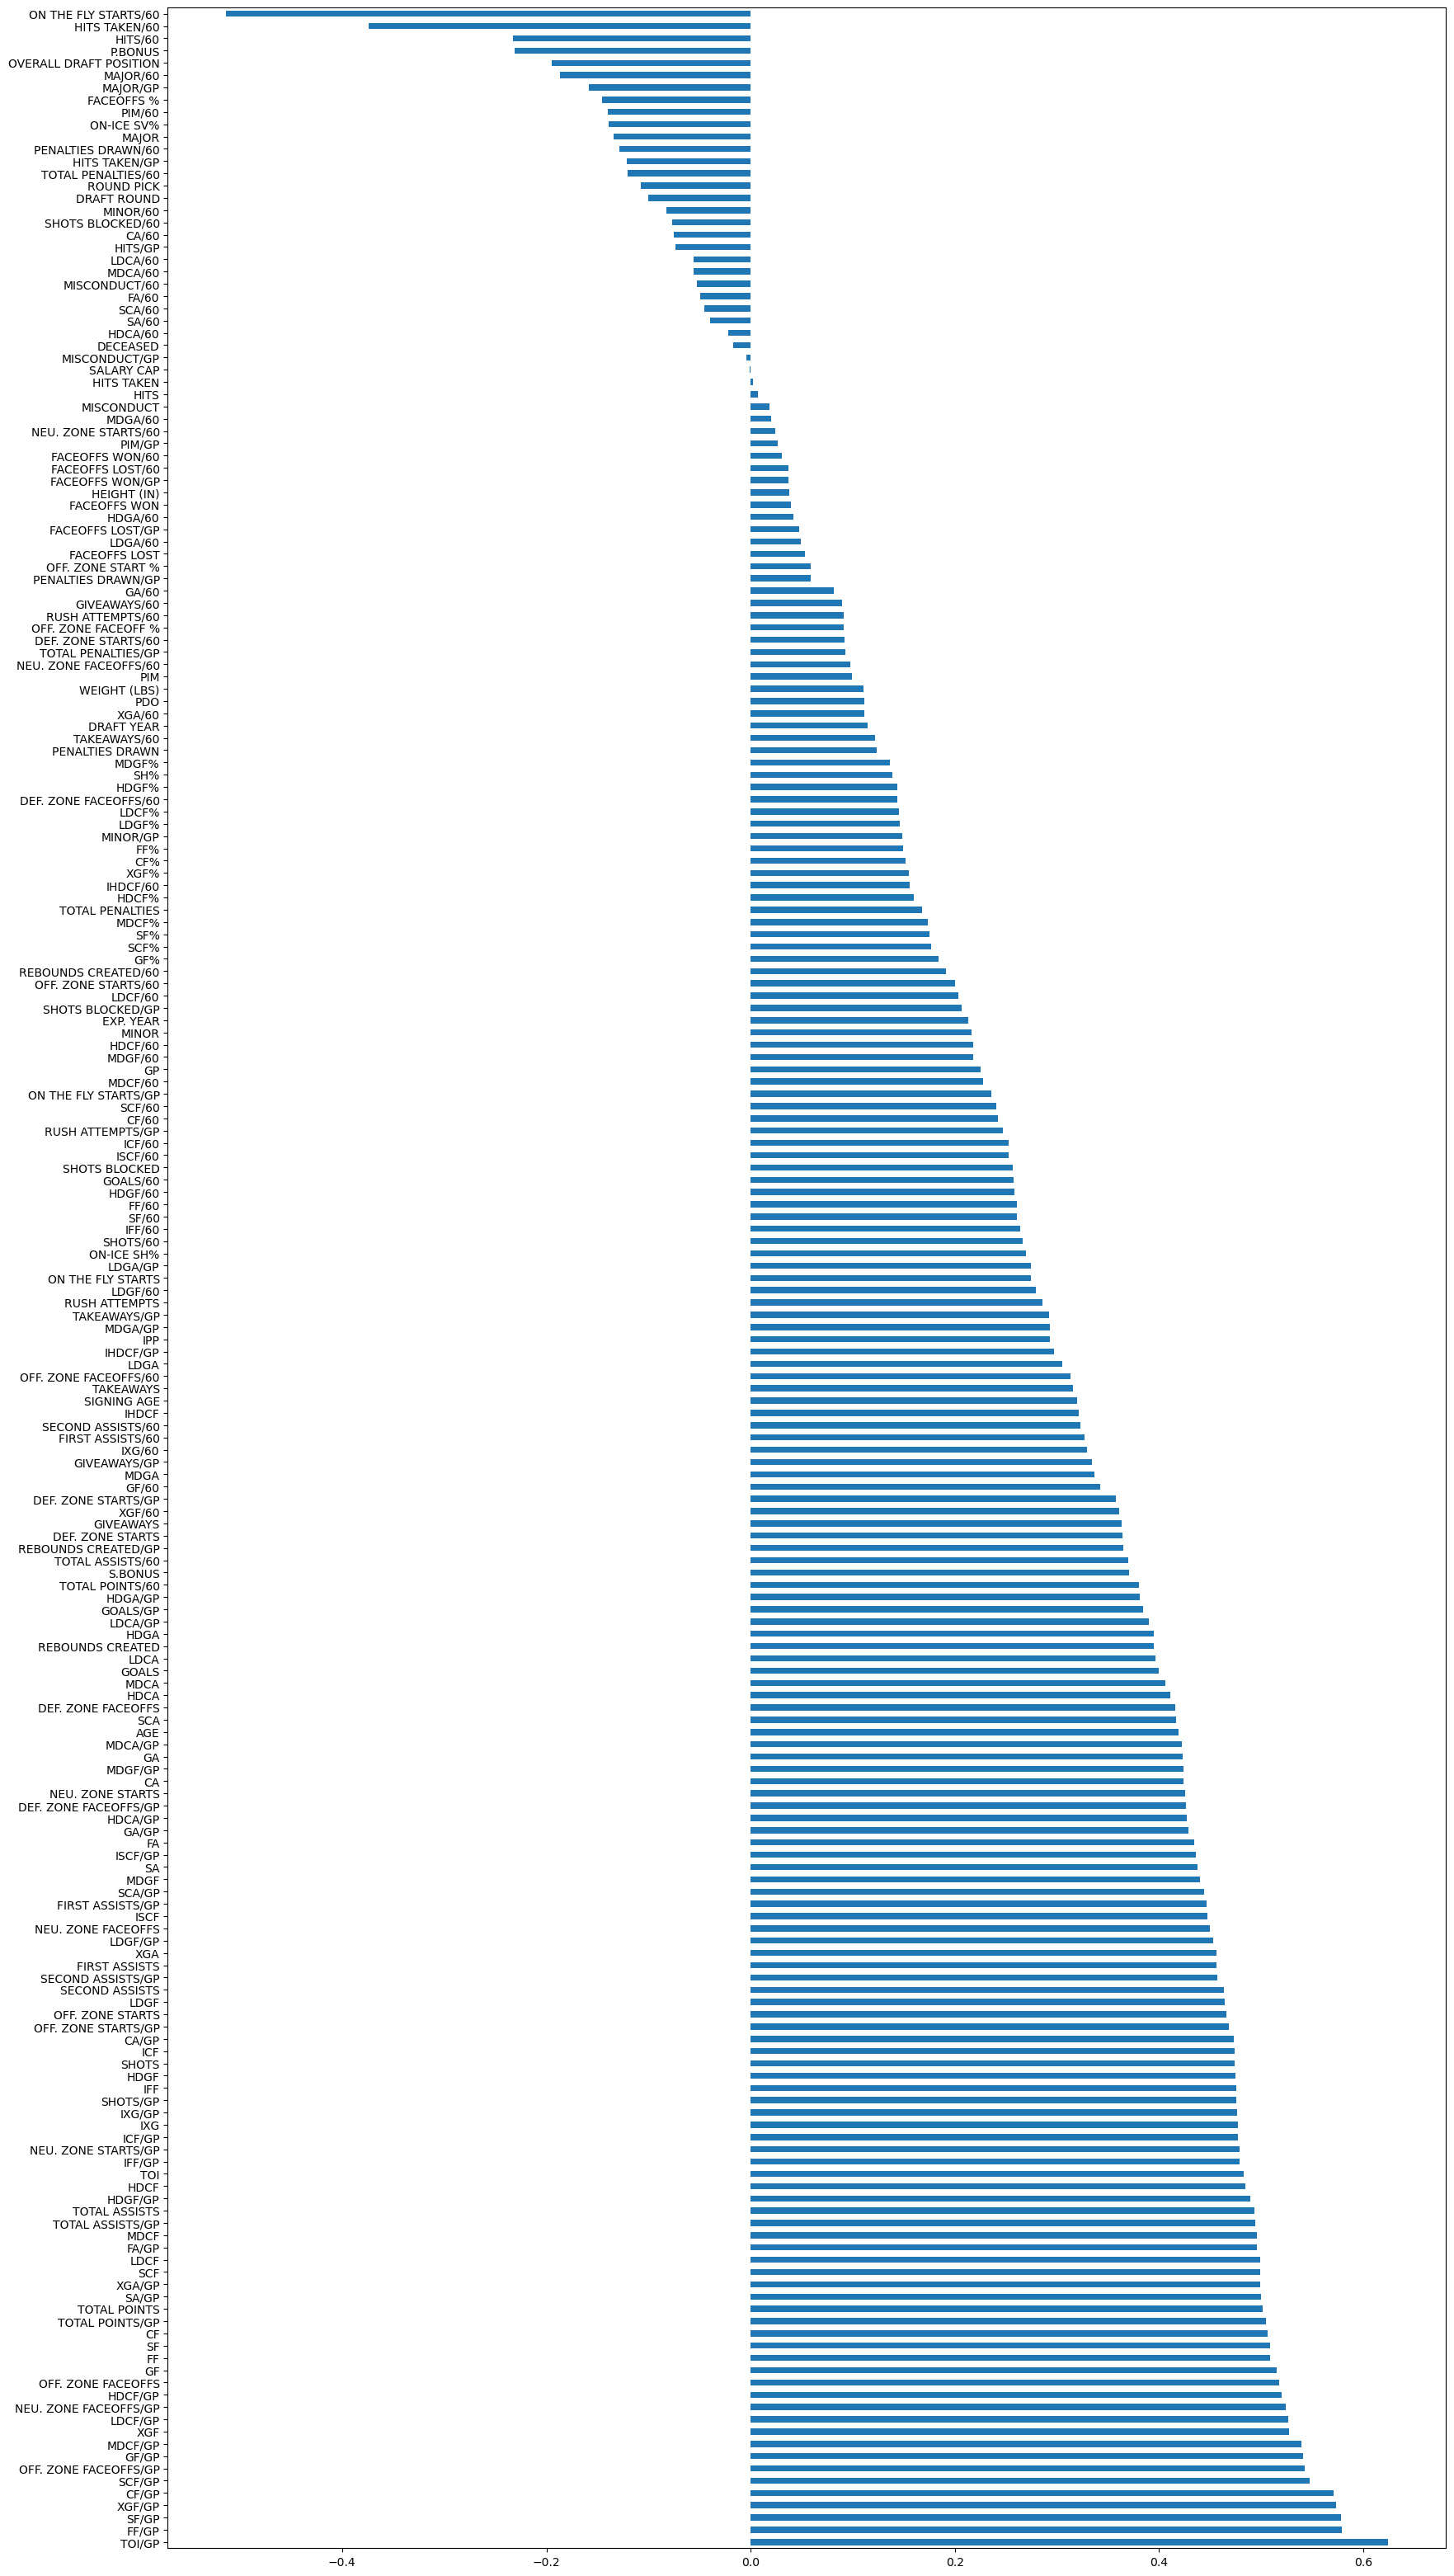

In [10]:
correlation_matrix = defensemen_41GP.corr()

# Extract all correlations with 'Y_SALARY_CAP_PERCENTAGE' and sort them
correlation_Y = correlation_matrix['SALARY CAP PERCENTAGE'].sort_values(ascending=False)

# Remove Y_SALARY_CAP_PERCENTAGE and LENGTH from the list
correlation_Y = correlation_Y.drop(['SALARY CAP PERCENTAGE', 'LENGTH', 'CAP HIT', 'AAV', 'SALARY', 'BASE SALARY'])

# Create a barplot of the correlations
plt.figure(figsize=(20, 40))
correlation_Y.plot(kind='barh')

This is looking pretty promising. One thing that may help is to pull out the top 15 or 20 features that have high absolute correlation values, and graph them.

In [23]:
# Sort the values of 'Y_SALARY_CAP_PERCENTAGE' by the absolute value
correlation_Y_abs = correlation_Y.abs().sort_values(ascending=False)

<Axes: >

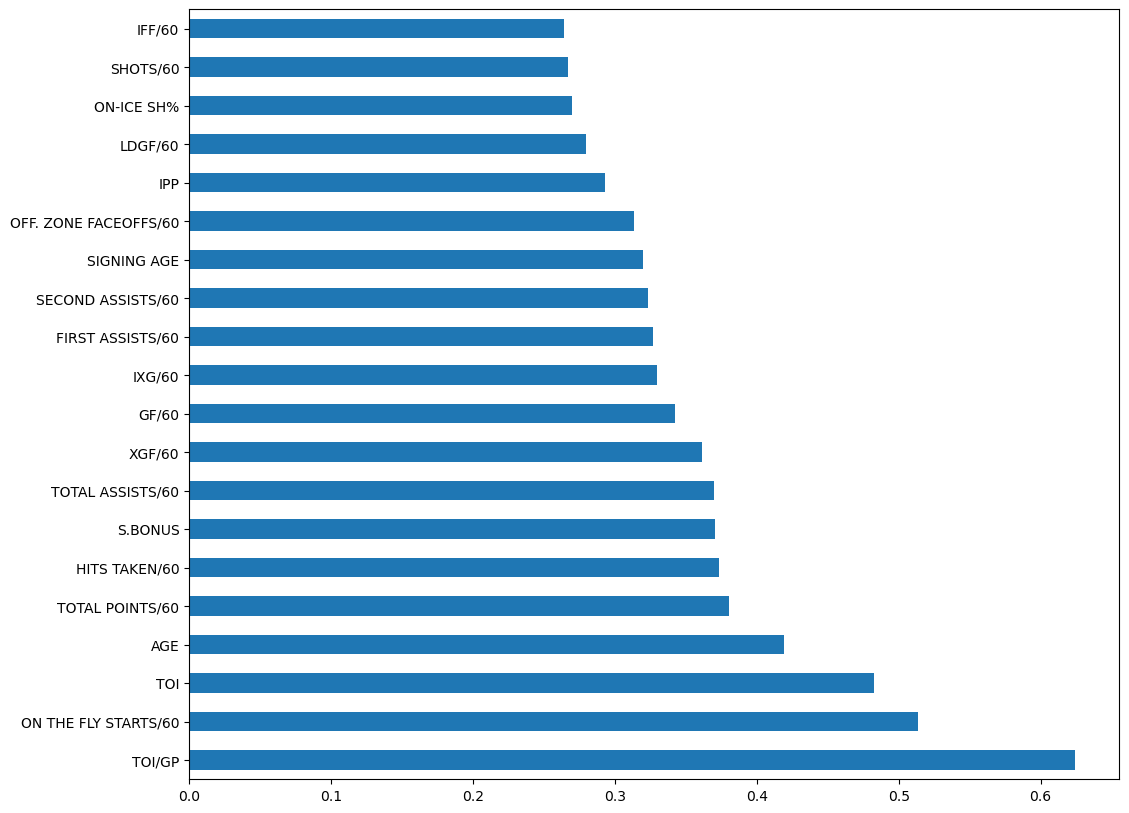

In [24]:
# Create a barplot of the top 20 correlations
plt.figure(figsize=(12, 10))
correlation_Y_abs[:20].plot(kind='barh')

In [ ]:
correlation_Y_abs[:15].index.tolist()

['TOI/GP',
 'ON\xa0THE\xa0FLY STARTS/60',
 'XGF/60',
 'TOTAL POINTS/60',
 'GF/60',
 'OFF.\xa0ZONE FACEOFFS/60',
 'TOTAL ASSISTS/60',
 'TOI',
 'FF/60',
 'SCF/60',
 'SF/60',
 'CF/60',
 'MDCF/60',
 'FIRST ASSISTS/60',
 'HDGF/60']

## Interesting Finding

Something I find quite interesting here is the strong (negative) correlation with On the fly starts per 60 minutes. An interesting element of hockey is the fact that players on the ice can swap with players on the bench, making an "on the fly" shift change in the middle of action. The strong negative correlation here with salary highlights the fact that these players come on the ice in the middle of play and are *less* likely to start play on the ice (at a face-off). This says something about game management and coaching decisions, suggesting that coaches want to start play with their best players on the ice. Players that frequently come onto the ice in the middle of play then are probably more likely to be used in specific game situations.

# Covariance Analysis

Next thing I'd like to look into is covariance analysis. Simply choosing the top features will not necessarily be useful if they are all themselves correlated. If we find that they are, it will probably make more sense to choose one and use that.

In [ ]:
# Extract the top 15 positively correlated features
top_20_features = correlation_Y[correlation_Y > 0].nlargest(30)

positive_corrs_df = centers[top_20_features.index]
positive_corrs = positive_corrs_df.corr()

## TOI/GP Multicollinearity Analysis

<Axes: >

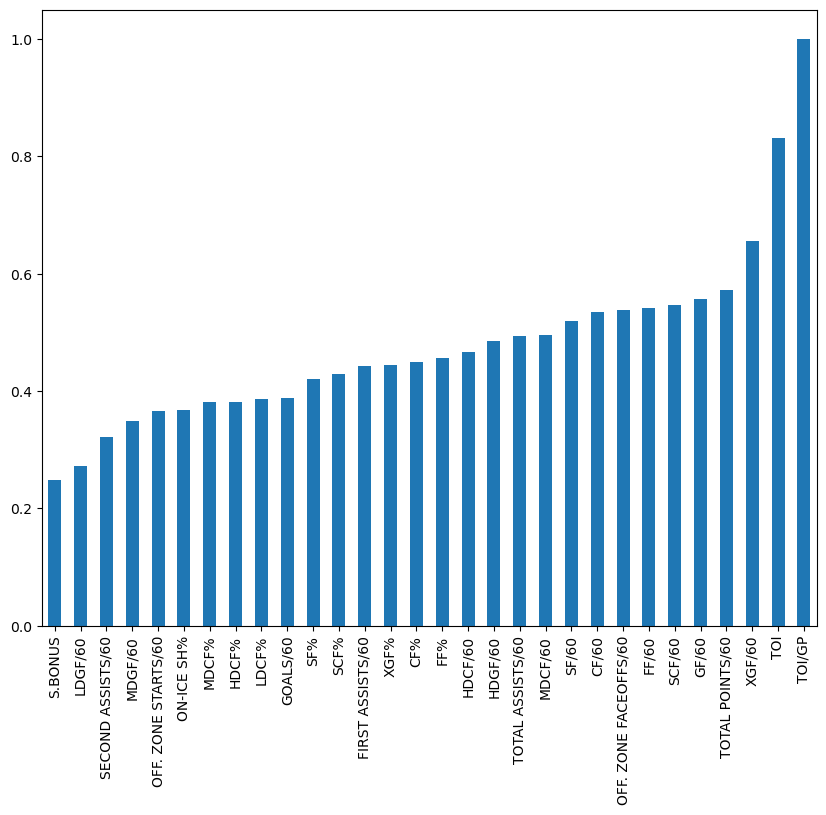

In [ ]:
# Sort positive_corrs by 'TOI/GP'
TOI_corrs = positive_corrs['TOI/GP'].sort_values()

# Plot a bar graph of TOI/GP vs. the top positively correlated features
plt.figure(figsize=(10, 8))
TOI_corrs.plot(kind='bar')

### Results

Here we see that Time on Ice per Game Played is highly correlated with TOI (no surprise there), and also with XGF/60 (Expected Goals For per 60 minutes). While it is still fairly strongly correlated with all the other features, it seems like it's probably going to be quite important to us.

## XGF/60 Multicollinearity Analysis

<Axes: >

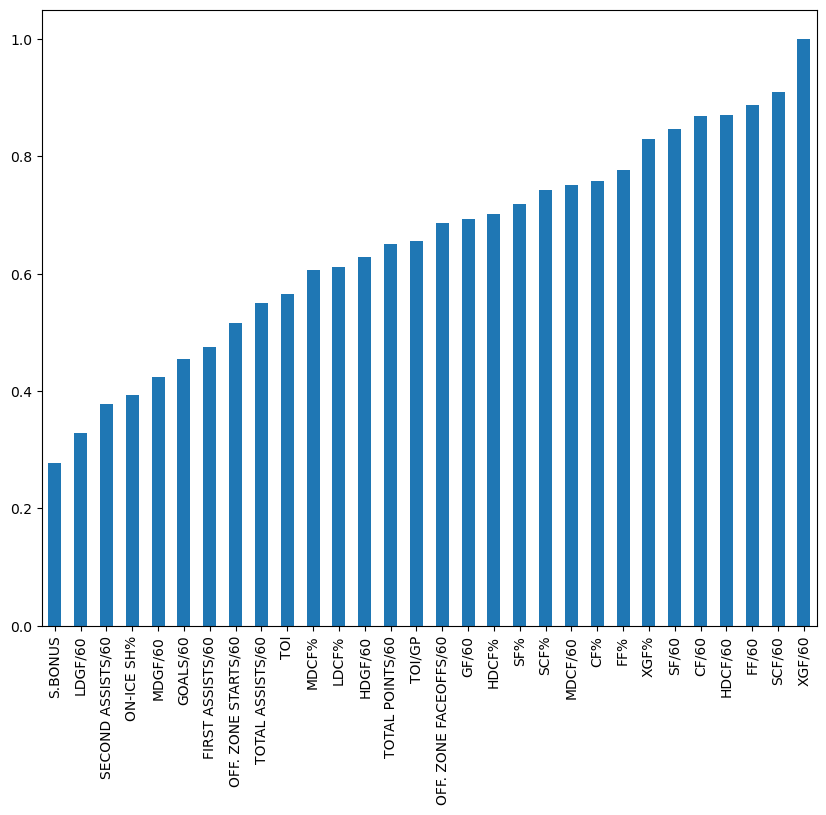

In [ ]:
# Sort positive_corrs by 'TOI/GP'
XGF_corrs = positive_corrs['XGF/60'].sort_values()

# Plot a bar graph of XGF/60 vs. the top positively correlated features, sorted by XGF/60
plt.figure(figsize=(10, 8))
XGF_corrs.plot(kind='bar')

### Results

Here we see a high degree of covariance across a large range of features, including SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60. My intuition says that XGF/60 is a very important feature that we should probably include, and we should probably feel free to ignore all of the previous features listed. In addition, if we look back at the correlation analysis across the entire table of features we see that XGF/60 is highly negatively correlated with On The Fly shifts per 60, which is actual more strongly correlated to our **y** values that XGF/60 when considering magnitude.

### IDEA - Dealing with Multicollinearity: Combining Highly Correlated features into a single new feature.

One idea that I came across that is apparently particularly useful for Linear Regression models is the idea of combining highly correlated features into a single new feature. Given how highly correlated XGF/60 is with SCF/60, FF/60, HDCF/60, CF/60, SF/60, it could be pretty reasonable to combine these features into a new feature instead of only using XGF/60.

## TOTAL POINTS/60 Multicollinearity Analysis

<Axes: >

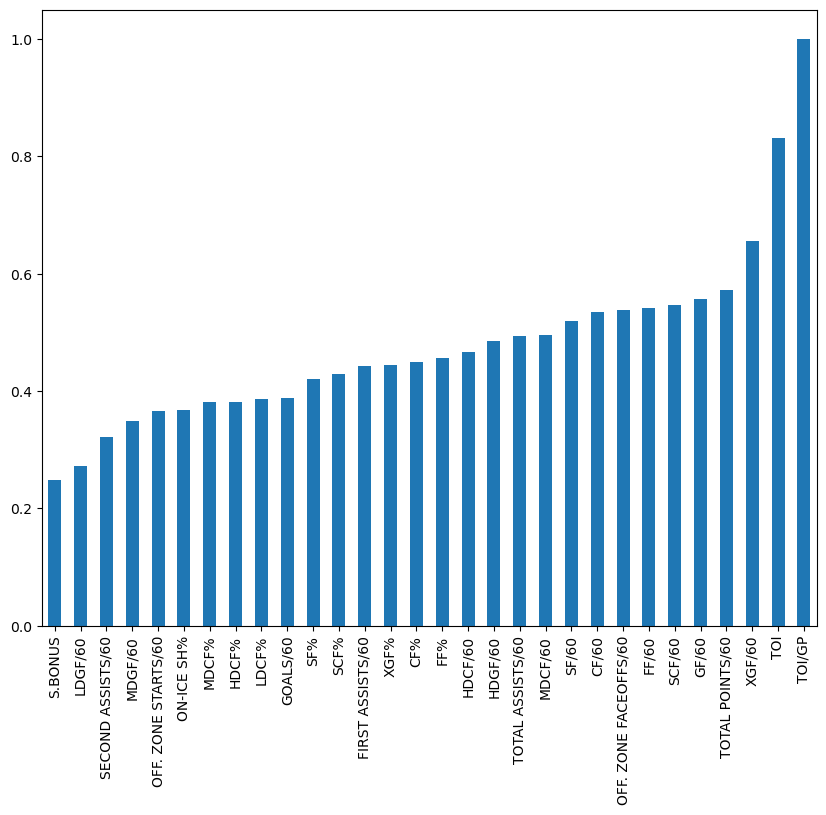

In [ ]:
# Sort positive_corrs by 'TOI/GP'
TP_corrs = positive_corrs['TOI/GP'].sort_values()

# Plot a bar graph of TOI/GP vs. the top positively correlated features
plt.figure(figsize=(10, 8))
TP_corrs.plot(kind='bar')

### Results

Somewhat unsurprisingly, Total Points/60 is highly correlated with GF/60 (Goals For per 60) and Total Assists per 60. Points are the sum of goals and assists, so there is no surprise here.

For our model, despite total points being so highly correlated with our **y** values, my intuition is to *not* use it as a feature and instead use both Total Assists/60 and GF/60 instead. Why? Because Total Points/60 is an aggregate column of two features that I suspect are not as correlated as one might guess. Lets take a look.

## GF/60 Multicollinearity Analysis

<Axes: >

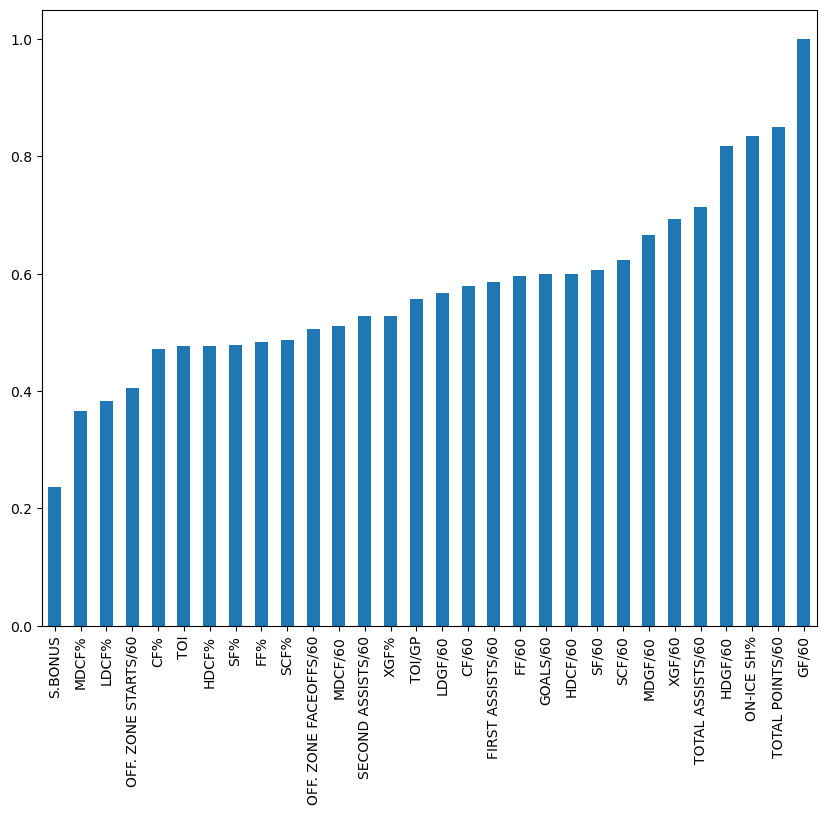

In [ ]:
# Sort positive_corrs by 'GF/60'
GF_corrs = positive_corrs['GF/60'].sort_values()

# Plot a bar graph of GF/60 vs. the top positively correlated features
plt.figure(figsize=(10, 8))
GF_corrs.plot(kind='bar')

### Results
Here we see that GF/60 has a correlational coefficient of 0.71 with Total Assists/60, which is high, but also probably a natural byproduct of sports analytics where variables will naturally tend to show some level of correlation.

GF/60 is also highly correlated with ON-ICE SH% (0.84).

We also see that GF/60 has a correlational coefficient of 0.82 with HDGF/60 (High Danger Goals For per 60). This metric is used to quantify a player's offensive performance, specifically focusing on the ability to score goals from high-danger areas on the ice, adjusted for time on ice. HDGF/60 is a valuable metric for assessing the quality of a player's offensive play, emphasizing not just the volume of shots or goals, but the quality of those chances. 

#### Thoughts
Due to their collinearilty, it probably makes sense to only use only GF/60 and HDGF/60 to drop ON-ICE SH%, despite the fact that they are interestings metrics.

## Total Assists/60 Multicollinearity Analysis

<Axes: >

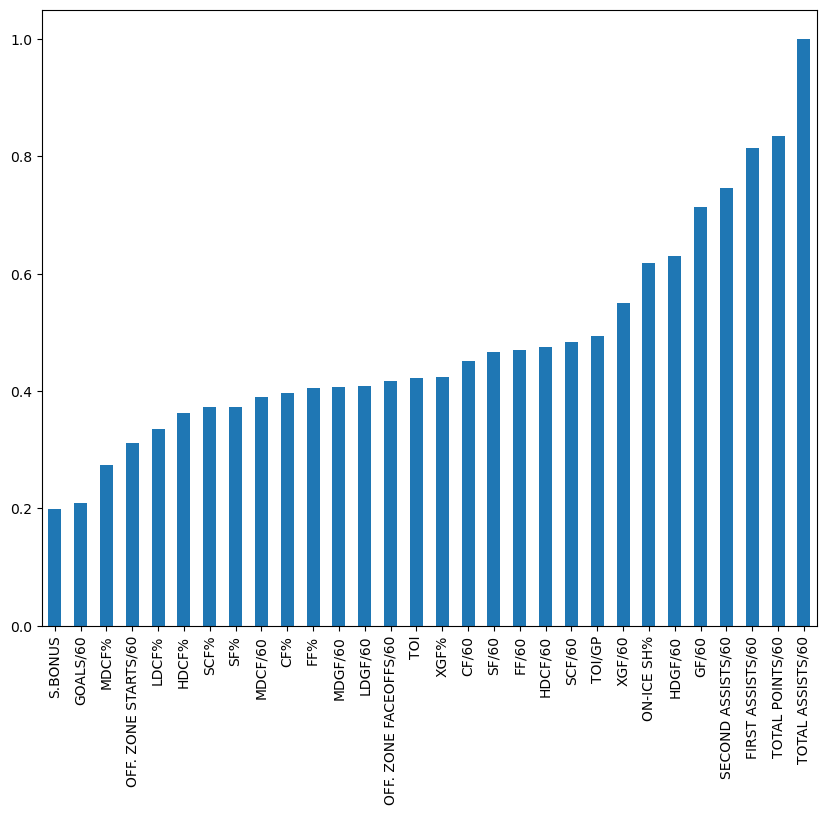

In [ ]:
# Sort positive_corrs by 'TOTAL ASSISTS/60'
TotAssists_corrs = positive_corrs['TOTAL ASSISTS/60'].sort_values()

# Plot a bar graph of TOTAL ASSISTS/60 vs. the top positively correlated features
plt.figure(figsize=(10, 8))
TotAssists_corrs.plot(kind='bar')

### Results
Here we see, without much surprise, that Total Assists is highly correlated with First Assists and Second Assists. For any goal in hockey, either 0, 1, or 2 assists can be awarded. A first assist means you were the last person to touch the puck before the goal scorer scored. A second assist means you were the second last person to touch the puck before the goal scorer scored.

#### Thoughts
It probably makes sense to try multiple models and see what works best. From a hockey standpoint, first assists and second assists are thought of somewhat differently, so a purist would want to use both; however, using one feature instead of two may offer better predictions.

## GOALS/60 Multicollinearity Analysis
Intuitively, goals scored are one of the most important things in hockey, because to win the game you need more goals than the opposing team. It is, in fact, quite surprising to me that GOALS/60 is not higher on the list of correlations with our **y** values. I suspect that it should be part of our model nevertheless (indeed, it would be very surprising if we chose *not* to use it).

<Axes: >

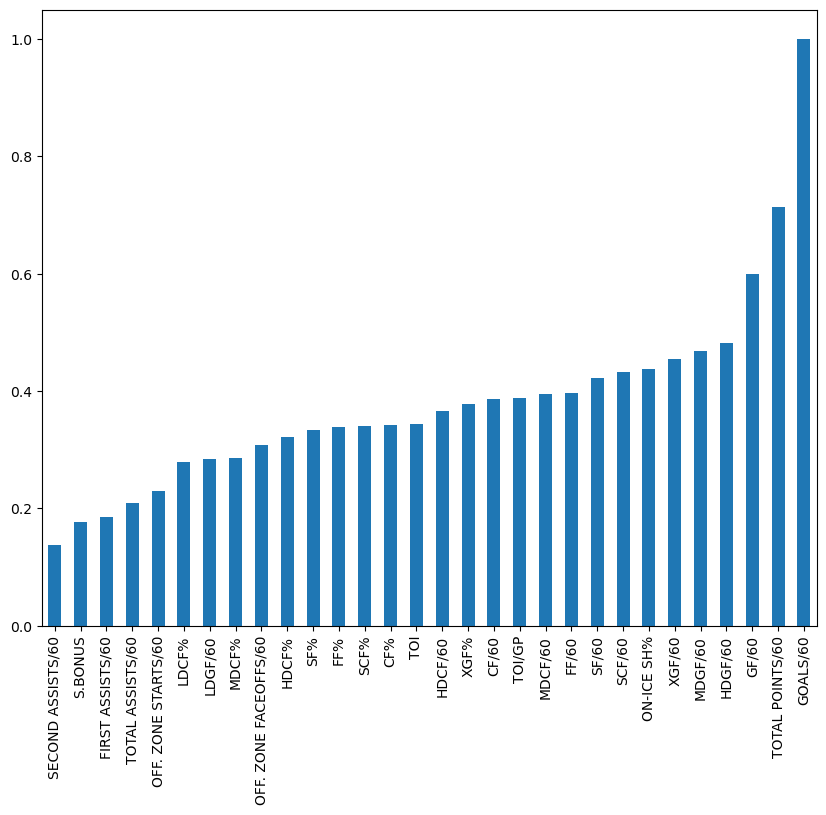

In [ ]:
# Sort positive_corrs by 'GOALS/60'
goals_corrs = positive_corrs['GOALS/60'].sort_values()

# Plot a bar graph of GOALS/60 vs. the top positively correlated features
plt.figure(figsize=(10, 8))
goals_corrs.plot(kind='bar')

### Results
It's quite interesting to notice that GOALS/60 is relatively modestly correlated with all other features except for Total Points/60 (which we have already determined we likely won't use), and GF/60 (Goals For per 60, which, for clarity, is more of a *team* statistic because it quantifies the number of goals for per 60 minutes that a player was on the ice for. I.e., it doesn't mean he scored them or even assisted on them.)

#### Thoughts
I think it makes a lot of sense to use GOALS/60 in our model and, in fact, would be strange not to.

# Non-Numerical Feature Analysis
Now that we have done a feature analysis for our numerical columns, we should take a look at our non-numerical columns and see if there is anything worth using.

In [ ]:
# Select all non-numerical columns from the centers_21GP df
non_numeric_columns = centers_21GP.select_dtypes(exclude=['number'])
non_numeric_columns

,POSITION,PLAYER,TEAM,DATE OF BIRTH,BIRTH CITY,BIRTH STATE/PROVINCE,BIRTH COUNTRY,NATIONALITY,DRAFT TEAM,COUNTRY,HANDED,DRAFTED,SIGNING TEAM,TYPE,CLAUSE,EXPIRY,SEASON
19,"c, l",andrew cogliano,col,1987-06-14,Toronto,ON,CAN,CAN,EDM,Canada,Left,25 - Round 1 - 2005 (EDM),EDM,Entry-Level,NaN,RFA,2007-08
28,c,antoine vermette,-,1982-07-20,St. Agapit,QC,CAN,CAN,OTT,Canada,Left,55 - Round 2 - 2000 (OTT),OTT,Standard (1-way),NaN,RFA,2007-08
30,c,anze kopitar,lak,1987-08-24,Jesenice,SVN,SVN,NaN,L.A,Slovenia,Left,11 - Round 1 - 2005 (LAK),LAK,Entry-Level,NaN,RFA,2007-08
40,c,boyd gordon,-,1983-10-19,Unity,SK,CAN,CAN,WSH,Canada,Right,17 - Round 1 - 2002 (WSH),WSH,Standard (1-way),NaN,RFA,2007-08
43,c,brad richards,-,1980-05-02,Murray Hbr.,PE,CAN,CAN,T.B,Canada,Left,64 - Round 3 - 1998 (TBL),TBL,Standard (1-way),NTC,UFA,2007-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12938,c,william karlsson,vgk,1993-01-08,Marsta,SWE,SWE,NaN,ANA,Sweden,Left,53 - Round 2 - 2011 (ANA),VGK,Standard (1-way),M-NTC,UFA,2023-24
12941,c,wyatt johnston,dal,2003-05-14,Toronto,ON,CAN,CAN,DAL,Canada,Right,23 - Round 1 - 2021 (DAL),DAL,Entry-Level,NaN,RFA,2023-24
12943,c,yakov trenin,col,1997-01-13,Chelyabinsk,RUS,RUS,NaN,NSH,Russia,Left,55 - Round 2 - 2015 (NSH),NSH,Standard (1-way),NaN,UFA,2023-24
12944,c,yanni gourde,sea,1991-12-15,Saint-Narcisse,QC,CAN,CAN,-,Canada,Left,-,TBL,Standard (1-way),M-NTC,UFA,2023-24


# One-Hot-Encoding
Most of these features do not seem like anything that should impact the value of a player based on their on-ice performace; however, there is one feature here that intruiges me: handedness. Players are either left-handed or right-handed, and one may be more rare than the other, so it may impact the equation of supply and demand on the market.

Let's do a quick analysis of the counts for each to see if we should use it in our feature space.

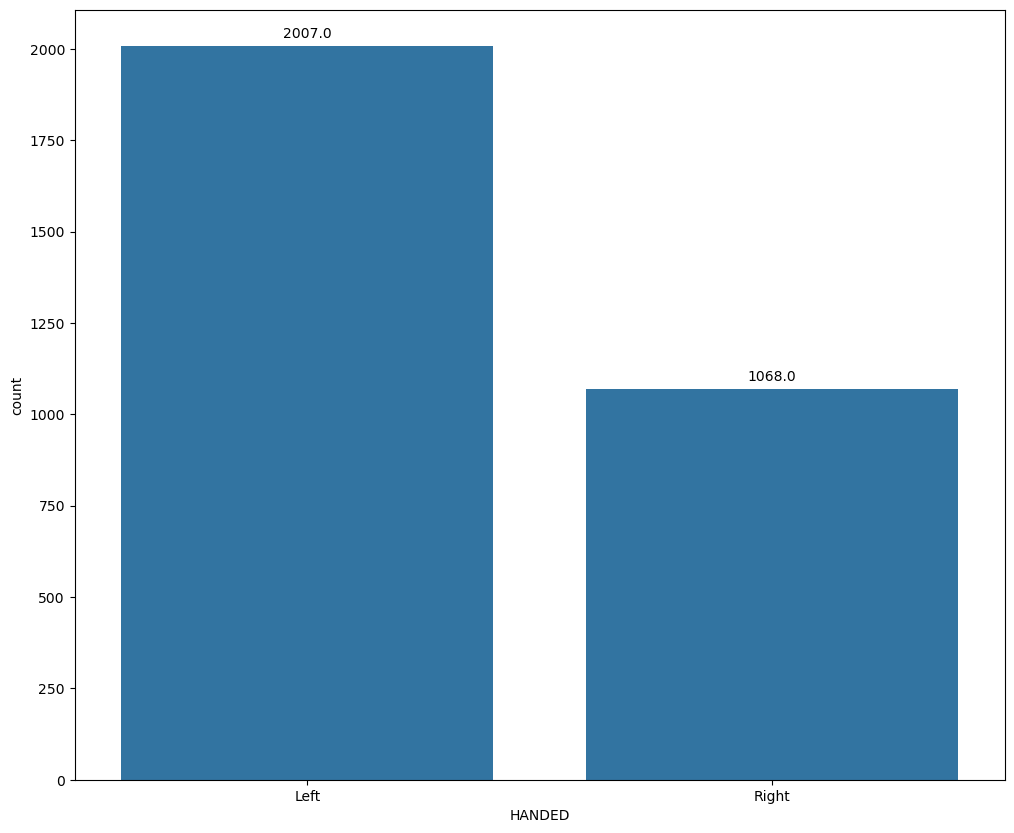

In [ ]:
# Assuming centers_21GP is your DataFrame and 'HANDED' is the column of interest
plt.figure(figsize=(12, 10))
ax = sns.countplot(data=centers_21GP, x='HANDED')

# Loop through each bar (patch) in the countplot
for p in ax.patches:
    # Get the height of the bar, which represents the count
    height = p.get_height()
    # Annotate the count above the bar
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), # Position for the annotation
                ha='center', va='center', # Alignment parameters
                xytext=(0, 9), # Distance from the top of the bar
                textcoords='offset points') # How the text is positioned

### Results
Interesting, as I suspected, the handedness is not distributed equally among players. Surprisingly, right handed centers are about half as common as left handed centers.

Text(0.5, 1.0, 'Salary Cap Percentage by Handedness')

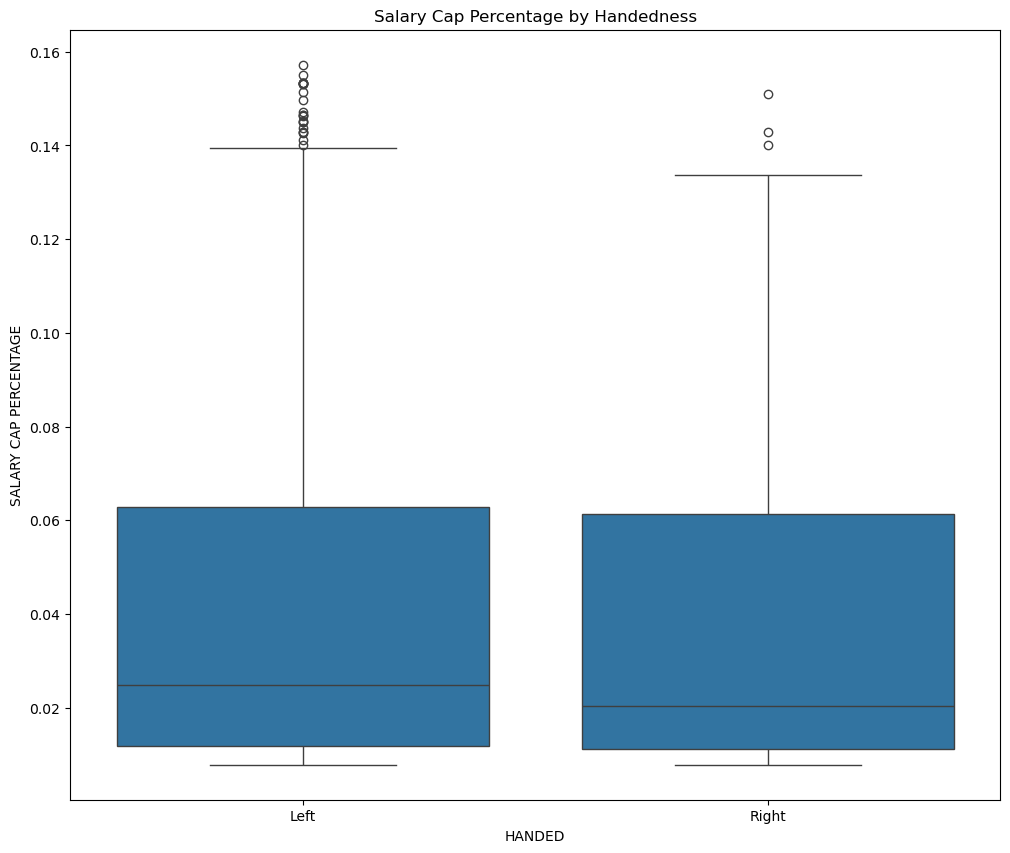

In [ ]:
# Visualize a boxplot showing the relationship between handedness and salary cap percentage
plt.figure(figsize=(12, 10))
sns.boxplot(data=centers_21GP, x='HANDED', y='SALARY CAP PERCENTAGE')

# Add a title to the plot
plt.title('Salary Cap Percentage by Handedness')

These results suggest that handedness may not in fact have a large impact on our model. Despite the fact that right handed centers are half as common, they do not seem to see a boost in market value.

# Conclusions on Numerical Features
Features to try include:
1. TOI/GP
2. XGF/60 - and possibly combining it with SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60 to create a new feature.
3. GF/60
4. TOTAL ASSISTS/60 - But possibly using FIRST ASSISTS/60 and SECOND_ASSISTS/60 instead.
5. GOALS/60

# Conclusions on Non-Numerical Features
There wasn't quite as much to consider here. I suspect we should not include handedness in our model.